We implement Spencer's no job left behind algorithm, looking forward an amount of time instead of a number of jobs.

In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [75]:
lambd = 0.999
mu1 = 0.95
mu2 = 100 # doesn't matter in this case because fast gets kicked out immediately
c = 1
Tmax = 60

p = 1 - mu1
surge_threshold = math.ceil(math.log(p / (1 - lambd), lambd / (1 - p)))
w = 60 # lookahead is online in this case

In [3]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 999999


def printarray(a): 
    print(np.around(a, 3))
    

# Define customer for the threshold policy
Customer = namedtuple("Customer", "arrival_time")
def customer(arrival_time=-1):
    return Customer(arrival_time=arrival_time)

# Define customer for the w-lookahead policy
# mu1 is the slow service rate and mu2 is the fast service rate
WCustomer = namedtuple("WCustomer", "arrival_time slow_service_time fast_service_time enter_service_time service_time arrival_index fast")
def wcustomer(arrival_time=-1, mu1=-1, mu2=-1, arrival_index=0):
    slow = exp(mu1)
    fast = 0 #slow * mu1/mu2
    return WCustomer(arrival_time=arrival_time, slow_service_time=slow,
                     fast_service_time=fast, enter_service_time=-1,
                     service_time=-1, arrival_index=arrival_index, fast=False)

def wcustomer_slow_fast(arrival_time=-1, slow=2, fast=0, arrival_index=0):
    return WCustomer(arrival_time=arrival_time, slow_service_time=slow,
                     fast_service_time=fast, enter_service_time=-1,
                     service_time=-1, arrival_index=arrival_index, fast=False)

def wcustomer_with_parameters(w, current_time, fast):
    if fast:
        return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                         fast_service_time=w.fast_service_time, enter_service_time=current_time,
                         service_time=current_time+w.fast_service_time,
                         arrival_index=w.arrival_index, fast=True)
    return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                     fast_service_time=w.fast_service_time, enter_service_time=current_time,
                     service_time=current_time+w.slow_service_time,
                     arrival_index=w.arrival_index, fast=False)

def wcustomer_deleted(w):
    return WCustomer(arrival_time=w.arrival_time, slow_service_time=0,
                     fast_service_time=w.fast_service_time, enter_service_time=w.enter_service_time,
                     service_time=w.service_time,
                     arrival_index=w.arrival_index, fast=True)

In [67]:
def gen_arrivals(lambd, mu1, mu2, Tmax): 
    # generate arrivals independent of whether or not we speed up the customers
    T_advance = [0]  # list of events that get generated in advance
    arrivals = []
    while T_advance[-1] < Tmax:
        t_temp = T_advance[-1]
        next_arrival = t_temp + exp(lambd)
        T_advance.append(next_arrival)
        arrivals.append(wcustomer(next_arrival, mu1, mu2, len(T_advance) - 2))
    return arrivals

In [5]:
def gen_deterministic_arrivals(lambd, mu1, mu2, Tmax): 
    # generate arrivals independent of whether or not we speed up the customers
    T_advance = [0]  # list of events that get generated in advance
    arrivals = []
    arrivals.append(wcustomer_slow_fast(0, 2, 0, 0))
    arrivals.append(wcustomer_slow_fast(1, 1, 0, 1))
    arrivals.append(wcustomer_slow_fast(4, 3, 0, 2))
    arrivals.append(wcustomer_slow_fast(5, 1, 0, 3))
    arrivals.append(wcustomer_slow_fast(6, 10, 0, 4))
    arrivals.append(wcustomer_slow_fast(9, 10, 0, 5))
    return arrivals

In [6]:
def gen_deletion_list(T, N):
    deletions = list()
    current_min = N[-1]
    for i in range(len(N) - 2, 0, -1):
        if N[i] < current_min:
            current_min = N[i]
            deletions.append(i + 1)
    return deletions

In [7]:
def execute_deletions(T, N):
    deletions = gen_deletion_list(T, N)
    #print(deletions)
    for i in deletions:
        for j in range(i, len(N)):
            N[j] -= 1
    return T, N, len(deletions) / len(N)

In [111]:
def gen_forward_deletions_2(T, D, w):
    if w > T[-1]:
        w = T[-1]
    
    lookahead = [min(t + w, T[-1]) for t in T]
    print(lookahead)
    done = np.zeros(len(D))
    
    walk_forward_index = 0
    deletion_index = 0
    
    sums_pointer = 0
    sums = np.zeros(len(D))
    
    deletion_count = 0
    deletions = np.zeros(len(D))
    min_lookahead = 0
    
    for i in range(len(D)):
        print("Current time %.2f" % (T[i]))
        this_increase = D[i]
        sums[i] += this_increase
        print(" outside changing at index %d to %d by %d" % (i, sums[i], this_increase))
        if sums[i] < 0:
            done[i] = 1
            print("index %d is done" % (i))
        
        start_loop = min_lookahead
        for j in range(start_loop, i):
            print("index %d current time %.2f time %.2f lookahead time %.2f" % (j, T[i], T[j], lookahead[j]))
            if T[i] < lookahead[j]:
                if done[j] == 0:
                    sums[j] += this_increase
                    print(" inside changing at index %d to %d by %d" % (j, sums[j], this_increase))
                    if sums[j] <= 0:
                        done[j] = 1
                        print("index %d is done" % (j))
            else:
                min_lookahead = j
                print("Update min lookahead to " + str(j))
    
    print(sums)
    print(done)
    
    for i in range(len(sums)):
        if sums[i] > 0 and D[i] == 1:
            print("Delete arrival index %d at time %.2f" % (i, T[i]))
            deletion_count += 1
        deletions[i] = deletion_count
    
    print(deletions)
    
    return deletions

In [112]:

deletions2 = gen_forward_deletions_2(T1.copy(), D1.copy(), 5)

[5, 5.721272639948483, 6.206543310426825, 6.571934718518413, 6.6186183486843175, 6.761058805249412, 6.856912947680971, 6.9300782459801935, 6.962038450425282, 8.34802291603624, 8.93304750598328, 10.421768255962263, 10.520545178997208, 10.571124231638983, 10.999597577522351, 11.22284659525065, 11.5214454766893, 11.671705342162031, 11.812444412603115, 12.586199327927881, 15.132281346662774, 15.45769405754981, 15.75691649987552, 16.00800992498196, 16.621323011192615, 17.904542488597805, 18.404567063860757, 18.408056124864657, 18.81003699279936, 19.156920527100745, 19.533100037933362, 19.93213495899234, 20.865970147792098, 22.55727780016345, 23.045588132782015, 23.45434261804488, 23.472543664909246, 23.98000147225201, 24.448555746711666, 24.80081199832948, 25.194132917287213, 25.781422129436013, 26.617658446201315, 27.169868708589505, 27.303944174041867, 28.725851194090584, 29.881152072381095, 30.913355711728187, 31.067738647338654, 31.956320184691485, 31.980560139996758, 32.348760966745274

 inside changing at index 101 to 2 by 1
Current time 51.29
 outside changing at index 103 to -1 by -1
index 103 is done
index 93 current time 51.29 time 45.98 lookahead time 50.98
Update min lookahead to 93
index 94 current time 51.29 time 46.68 lookahead time 51.68
 inside changing at index 94 to 6 by -1
index 95 current time 51.29 time 47.61 lookahead time 52.61
 inside changing at index 95 to 5 by -1
index 96 current time 51.29 time 48.41 lookahead time 53.41
 inside changing at index 96 to 4 by -1
index 97 current time 51.29 time 48.93 lookahead time 53.93
index 98 current time 51.29 time 49.18 lookahead time 54.18
index 99 current time 51.29 time 50.39 lookahead time 55.39
 inside changing at index 99 to 3 by -1
index 100 current time 51.29 time 51.01 lookahead time 56.01
 inside changing at index 100 to 2 by -1
index 101 current time 51.29 time 51.07 lookahead time 56.07
 inside changing at index 101 to 1 by -1
index 102 current time 51.29 time 51.07 lookahead time 56.07
 inside 

In [113]:

deletions4 = gen_forward_deletions_2(T1.copy(), D1.copy(), 0.1)

[0.1, 0.8212726399484828, 1.3065433104268247, 1.671934718518413, 1.7186183486843176, 1.8610588052494124, 1.9569129476809715, 2.0300782459801936, 2.0620384504252818, 3.448022916036239, 4.033047505983281, 5.521768255962264, 5.620545178997208, 5.671124231638983, 6.099597577522352, 6.322846595250649, 6.621445476689299, 6.771705342162031, 6.912444412603115, 7.686199327927881, 10.232281346662774, 10.55769405754981, 10.856916499875519, 11.108009924981959, 11.721323011192613, 13.004542488597805, 13.504567063860756, 13.508056124864659, 13.91003699279936, 14.256920527100743, 14.633100037933362, 15.032134958992339, 15.965970147792097, 17.657277800163452, 18.145588132782017, 18.55434261804488, 18.572543664909247, 19.08000147225201, 19.548555746711667, 19.90081199832948, 20.294132917287214, 20.881422129436015, 21.717658446201316, 22.269868708589506, 22.403944174041868, 23.825851194090585, 24.981152072381096, 26.013355711728188, 26.167738647338656, 27.056320184691486, 27.08056013999676, 27.448760966

In [9]:
def gen_forward_deletions(T, D, w):
    if w > len(D) - 1:
        w = len(D) - 1
    
    walk_forward_index = 0
    deletion_index = 0
    
    sums_pointer = 0
    sums = np.zeros(w)
    
    deletion_count = 0
    deletions = np.zeros(len(D))
    
    print("Initial loop")
    # initial population of sums array
    for i in range(w):
        walk_forward_index = i
        #print(D[walk_forward_index])
        for j in range(0, i + 1):
            if sums[j] > 0:
                sums[j] += D[walk_forward_index]
        sums[i] += D[walk_forward_index]
        #print(sums)
    
    if sums[sums_pointer] > 0 and D[deletion_index] == 1:
        deletion_count += 1
    deletions[deletion_index] = deletion_count
    deletion_index += 1
    sums[sums_pointer] = 0
    #print("Sums " + str(sums))
    
    #print(sums_pointer)
    
    print("Walk forward loop")
    
    for i in range(w, len(D) - w - 1):
        walk_forward_index = i
        #print("Next: " + str(D[walk_forward_index]))
        for j in range(len(sums)):
            if sums[j] > 0:
                sums[j] += D[walk_forward_index]
        sums[sums_pointer] += D[walk_forward_index]
        
        sums_pointer += 1
        if sums_pointer == w:
            sums_pointer = 0
        if sums[sums_pointer] > 0 and D[deletion_index] == 1:
            deletion_count += 1
        deletions[deletion_index] = deletion_count
        deletion_index += 1
        sums[sums_pointer] = 0 
        #print(sums)
    
    #print(sums_pointer)
    
    print("Last loop")
    
    for i in range(len(D) - w - 1, len(D) - 1):
        walk_forward_index = i
        #print("Next: " + str(D[walk_forward_index]))
        for j in range(len(sums)):
            if sums[j] > 0:
                sums[j] += D[walk_forward_index]
        sums[sums_pointer] += D[walk_forward_index]
        
        sums_pointer += 1
        if sums_pointer == w:
            sums_pointer = 0
        if sums[sums_pointer] > 0 and D[deletion_index] == 1:
            deletion_count += 1
        deletions[deletion_index] = deletion_count
        deletion_index += 1
        sums[sums_pointer] = 0 
        #print(sums)
    
    #print(sums_pointer)
    print("Deletions")
    
    return deletions

In [10]:
# Implement no policy (always use slow service time) on an array of arrivals.
# Returns T, N, D, waiting times. Proportion of surge is always 0.
def MM1Normal(arrivals, c, Tmax):
    T             = [0]  # list of times that events occur in real time
    N             = [0]  # initial state of the system
    D             = [0]  # arrivals and departures list
    
    # customers currently being served by a server
    servers = []
    
    # customers that are waiting to be served by a server
    queue = []
    
    # times spent by users inside the system
    waiting_times = []
    
    # arrival index represents when we either add to queue or to server if it's free
    arrival_index = 0
    arrivals_len = len(arrivals) - 1
    
    # first event must be an arrival
    next_arrival = arrivals[arrival_index].arrival_time
    next_departure = inf()
    
    while T[-1] < Tmax:
        T.append(min(next_arrival, next_departure))
        
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1] + 1) 
            D.append(1)
            arrival = arrivals[arrival_index]
            arrival_index += 1
            if len(servers) < c:
                servers.append(wcustomer_with_parameters(arrival, T[-1], False))
            else:
                queue.append(arrival)
                
        ##### DEPARTURE #####     
        elif T[-1] == next_departure:
            N.append(N[-1] - 1)
            D.append(-1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
            # put the next person from the queue into the server
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                servers.append(wcustomer_with_parameters(next_to_enter, T[-1], False))
        
        if arrival_index < len(arrivals):
            next_arrival = arrivals[arrival_index].arrival_time
        else:
            next_arrival = inf()
        
        if len(servers) > 0:
            next_departure = servers[0].service_time
        else:
            next_departure = inf()
        
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    D = D[1:]
    return T, N, D, waiting_times

# Graphs and Results

In [11]:
# Start and end proportions for graphing
start_prop = 0 #0.055
end_prop = 1.2 #0.058

In [92]:
arrivals = gen_arrivals(lambd, mu1, mu2, Tmax)



Initial loop
Walk forward loop
Last loop
Deletions
[58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.963792442

index 1 current time 26.96 time 0.72 lookahead time 58.96
index 2 current time 26.96 time 1.21 lookahead time 58.96
index 3 current time 26.96 time 1.57 lookahead time 58.96
index 4 current time 26.96 time 1.62 lookahead time 58.96
index 5 current time 26.96 time 1.76 lookahead time 58.96
index 6 current time 26.96 time 1.86 lookahead time 58.96
index 7 current time 26.96 time 1.93 lookahead time 58.96
index 8 current time 26.96 time 1.96 lookahead time 58.96
index 9 current time 26.96 time 3.35 lookahead time 58.96
index 10 current time 26.96 time 3.93 lookahead time 58.96
index 11 current time 26.96 time 5.42 lookahead time 58.96
index 12 current time 26.96 time 5.52 lookahead time 58.96
index 13 current time 26.96 time 5.57 lookahead time 58.96
index 14 current time 26.96 time 6.00 lookahead time 58.96
index 15 current time 26.96 time 6.22 lookahead time 58.96
index 16 current time 26.96 time 6.52 lookahead time 58.96
index 17 current time 26.96 time 6.67 lookahead time 58.96
index 

index 60 current time 36.35 time 30.74 lookahead time 58.96
index 61 current time 36.35 time 31.56 lookahead time 58.96
index 62 current time 36.35 time 32.22 lookahead time 58.96
index 63 current time 36.35 time 32.35 lookahead time 58.96
index 64 current time 36.35 time 32.86 lookahead time 58.96
index 65 current time 36.35 time 33.71 lookahead time 58.96
 inside changing at index 65 to 3 by -1
index 66 current time 36.35 time 34.21 lookahead time 58.96
index 67 current time 36.35 time 34.50 lookahead time 58.96
index 68 current time 36.35 time 34.92 lookahead time 58.96
 inside changing at index 68 to 2 by -1
index 69 current time 36.35 time 35.10 lookahead time 58.96
 inside changing at index 69 to 1 by -1
index 70 current time 36.35 time 36.34 lookahead time 58.96
 inside changing at index 70 to 0 by -1
index 70 is done
Current time 36.45
 outside changing at index 72 to -1 by -1
index 72 is done
index 0 current time 36.45 time 0.00 lookahead time 58.96
index 1 current time 36.45 

 inside changing at index 68 to 5 by -1
index 69 current time 43.65 time 35.10 lookahead time 58.96
index 70 current time 43.65 time 36.34 lookahead time 58.96
index 71 current time 43.65 time 36.35 lookahead time 58.96
index 72 current time 43.65 time 36.45 lookahead time 58.96
index 73 current time 43.65 time 38.39 lookahead time 58.96
index 74 current time 43.65 time 38.70 lookahead time 58.96
index 75 current time 43.65 time 39.52 lookahead time 58.96
 inside changing at index 75 to 4 by -1
index 76 current time 43.65 time 39.54 lookahead time 58.96
 inside changing at index 76 to 3 by -1
index 77 current time 43.65 time 39.69 lookahead time 58.96
index 78 current time 43.65 time 40.25 lookahead time 58.96
index 79 current time 43.65 time 40.62 lookahead time 58.96
 inside changing at index 79 to 2 by -1
index 80 current time 43.65 time 40.70 lookahead time 58.96
index 81 current time 43.65 time 40.75 lookahead time 58.96
index 82 current time 43.65 time 41.14 lookahead time 58.96


 inside changing at index 95 to 6 by 1
index 96 current time 51.07 time 48.41 lookahead time 58.96
 inside changing at index 96 to 5 by 1
index 97 current time 51.07 time 48.93 lookahead time 58.96
index 98 current time 51.07 time 49.18 lookahead time 58.96
index 99 current time 51.07 time 50.39 lookahead time 58.96
 inside changing at index 99 to 4 by 1
index 100 current time 51.07 time 51.01 lookahead time 58.96
 inside changing at index 100 to 3 by 1
index 101 current time 51.07 time 51.07 lookahead time 58.96
 inside changing at index 101 to 2 by 1
Current time 51.29
 outside changing at index 103 to -1 by -1
index 103 is done
index 0 current time 51.29 time 0.00 lookahead time 58.96
index 1 current time 51.29 time 0.72 lookahead time 58.96
index 2 current time 51.29 time 1.21 lookahead time 58.96
index 3 current time 51.29 time 1.57 lookahead time 58.96
index 4 current time 51.29 time 1.62 lookahead time 58.96
index 5 current time 51.29 time 1.76 lookahead time 58.96
index 6 curre

index 8 current time 55.52 time 1.96 lookahead time 58.96
index 9 current time 55.52 time 3.35 lookahead time 58.96
index 10 current time 55.52 time 3.93 lookahead time 58.96
index 11 current time 55.52 time 5.42 lookahead time 58.96
index 12 current time 55.52 time 5.52 lookahead time 58.96
index 13 current time 55.52 time 5.57 lookahead time 58.96
index 14 current time 55.52 time 6.00 lookahead time 58.96
index 15 current time 55.52 time 6.22 lookahead time 58.96
index 16 current time 55.52 time 6.52 lookahead time 58.96
index 17 current time 55.52 time 6.67 lookahead time 58.96
index 18 current time 55.52 time 6.81 lookahead time 58.96
index 19 current time 55.52 time 7.59 lookahead time 58.96
index 20 current time 55.52 time 10.13 lookahead time 58.96
index 21 current time 55.52 time 10.46 lookahead time 58.96
index 22 current time 55.52 time 10.76 lookahead time 58.96
index 23 current time 55.52 time 11.01 lookahead time 58.96
index 24 current time 55.52 time 11.62 lookahead time 

index 11 current time 6.81 time 5.42 lookahead time 25.42
index 12 current time 6.81 time 5.52 lookahead time 25.52
index 13 current time 6.81 time 5.57 lookahead time 25.57
index 14 current time 6.81 time 6.00 lookahead time 26.00
index 15 current time 6.81 time 6.22 lookahead time 26.22
index 16 current time 6.81 time 6.52 lookahead time 26.52
index 17 current time 6.81 time 6.67 lookahead time 26.67
 inside changing at index 17 to 2 by 1
Current time 7.59
 outside changing at index 19 to 1 by 1
index 0 current time 7.59 time 0.00 lookahead time 20.00
 inside changing at index 0 to 4 by 1
index 1 current time 7.59 time 0.72 lookahead time 20.72
index 2 current time 7.59 time 1.21 lookahead time 21.21
index 3 current time 7.59 time 1.57 lookahead time 21.57
index 4 current time 7.59 time 1.62 lookahead time 21.62
index 5 current time 7.59 time 1.76 lookahead time 21.76
index 6 current time 7.59 time 1.86 lookahead time 21.86
index 7 current time 7.59 time 1.93 lookahead time 21.93
ind

index 35 current time 26.07 time 18.45 lookahead time 38.45
index 36 current time 26.07 time 18.47 lookahead time 38.47
index 37 current time 26.07 time 18.98 lookahead time 38.98
index 38 current time 26.07 time 19.45 lookahead time 39.45
index 39 current time 26.07 time 19.80 lookahead time 39.80
index 40 current time 26.07 time 20.19 lookahead time 40.19
index 41 current time 26.07 time 20.78 lookahead time 40.78
index 42 current time 26.07 time 21.62 lookahead time 41.62
index 43 current time 26.07 time 22.17 lookahead time 42.17
index 44 current time 26.07 time 22.30 lookahead time 42.30
 inside changing at index 44 to 1 by -1
index 45 current time 26.07 time 23.73 lookahead time 43.73
index 46 current time 26.07 time 24.88 lookahead time 44.88
index 47 current time 26.07 time 25.91 lookahead time 45.91
 inside changing at index 47 to 0 by -1
index 47 is done
Current time 26.96
 outside changing at index 49 to 1 by 1
index 14 current time 26.96 time 6.00 lookahead time 26.00
Updat

 outside changing at index 81 to -1 by -1
index 81 is done
index 40 current time 40.75 time 20.19 lookahead time 40.19
Update min lookahead to 40
index 41 current time 40.75 time 20.78 lookahead time 40.78
index 42 current time 40.75 time 21.62 lookahead time 41.62
index 43 current time 40.75 time 22.17 lookahead time 42.17
index 44 current time 40.75 time 22.30 lookahead time 42.30
 inside changing at index 44 to 6 by -1
index 45 current time 40.75 time 23.73 lookahead time 43.73
index 46 current time 40.75 time 24.88 lookahead time 44.88
index 47 current time 40.75 time 25.91 lookahead time 45.91
index 48 current time 40.75 time 26.07 lookahead time 46.07
index 49 current time 40.75 time 26.96 lookahead time 46.96
index 50 current time 40.75 time 26.98 lookahead time 46.98
index 51 current time 40.75 time 27.35 lookahead time 47.35
index 52 current time 40.75 time 27.36 lookahead time 47.36
index 53 current time 40.75 time 27.40 lookahead time 47.40
index 54 current time 40.75 time 2

 inside changing at index 99 to 3 by 1
index 100 current time 52.64 time 51.01 lookahead time 58.96
index 101 current time 52.64 time 51.07 lookahead time 58.96
index 102 current time 52.64 time 51.07 lookahead time 58.96
index 103 current time 52.64 time 51.29 lookahead time 58.96
index 104 current time 52.64 time 51.42 lookahead time 58.96
index 105 current time 52.64 time 51.71 lookahead time 58.96
index 106 current time 52.64 time 51.86 lookahead time 58.96
 inside changing at index 106 to 2 by 1
Current time 52.87
 outside changing at index 108 to -1 by -1
index 108 is done
index 63 current time 52.87 time 32.35 lookahead time 52.35
Update min lookahead to 63
index 64 current time 52.87 time 32.86 lookahead time 52.86
Update min lookahead to 64
index 65 current time 52.87 time 33.71 lookahead time 53.71
 inside changing at index 65 to 10 by -1
index 66 current time 52.87 time 34.21 lookahead time 54.21
index 67 current time 52.87 time 34.50 lookahead time 54.50
index 68 current ti

Text(0.5,1,'Number of clients in the M/M/C queue 1.00/0.95/1, with no policy')

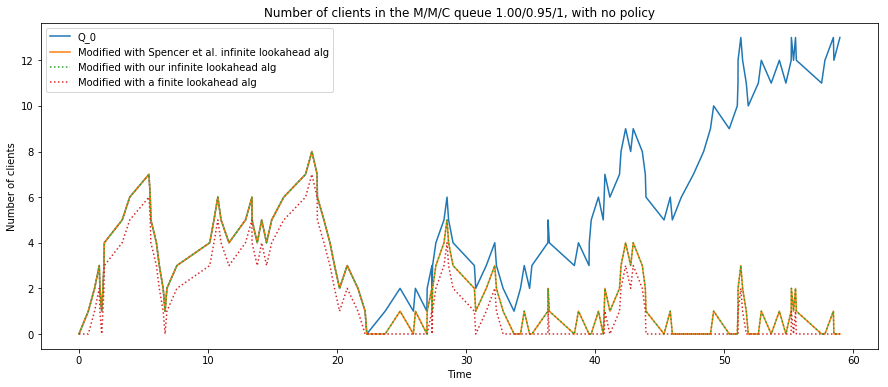

In [118]:
T1, N1, D1, _ = MM1Normal(arrivals, c, Tmax)
T4, N4, surge_prop = execute_deletions(T1, N1.copy())
deletions = gen_forward_deletions(T1.copy(), D1.copy(), 10000)
deletions2 = gen_forward_deletions_2(T1.copy(), D1.copy(), 10000)
deletions3 = gen_forward_deletions_2(T1.copy(), D1.copy(), 20)
modified = [max(0, i) for i in N1.copy() - deletions]
modified2 = [max(0, i) for i in N1.copy() - deletions2]
modified3 = [max(0, i) for i in N1.copy() - deletions3]
print("No Job Left Behind Surge Proportion %.2f" % (surge_prop))
start_index1 = int(len(T1)*start_prop)
end_index1 = int(len(T1)*end_prop)
figure(figsize=(15,6))
plot(T1[start_index1:end_index1], N1[start_index1:end_index1], label="Q_0")
plot(T4[start_index1:end_index1], N4[start_index1:end_index1], label="Modified with Spencer et al. infinite lookahead alg")
plot(T1[start_index1:end_index1], modified[start_index1:end_index1], label="Modified with our infinite lookahead alg", linestyle=":")
plot(T1[start_index1:end_index1], modified3[start_index1:end_index1], label="Modified with a finite lookahead alg", linestyle=":")
xlabel('Time')
ylabel('Number of clients')
legend()
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with no policy' % (lambd, mu1, c))

In [ ]:
# look up the lookahead time needed

In [ ]:
'''T3, N3, _, use_surge = MM1WithWLookaheadConstant(arrivals, c, w, Tmax)

start_index3 = int(len(T3)*start_prop)
end_index3 = int(len(T3)*end_prop)
figure(figsize=(15,6))
#scatter(T3[start_index:end_index], N3[start_index:end_index])
plot(T3[start_index3:end_index3], N3[start_index3:end_index3])
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with w-lookahead online'
      % (lambd, mu1, c))
print("Use surge %.2f" % (use_surge))'''

In [ ]:
T2, N2, _, use_surge = MM1WithOneThreshold(arrivals, surge_threshold, c, Tmax)

start_index2 = int(len(T2)*start_prop)
end_index2 = int(len(T2)*end_prop)
figure(figsize=(15,6))
plot(T2[start_index2:end_index2], N2[start_index2:end_index2])
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with threshold %d'
      % (lambd, mu1, c, surge_threshold))
print("Use surge %.2f" % (use_surge))

In [ ]:
figure(figsize=(15,7))
plot(T1[start_index1:end_index1], N1[start_index1:end_index1], label="Q_0")
plot(T2[start_index2:end_index2], N2[start_index2:end_index2], label="after applying threshold=78")
#plot(T3[start_index3:end_index3], N3[start_index3:end_index3], label="after applying no job left behind")
plot(T4[start_index1:end_index1], N4[start_index1:end_index1], label="after applying no job left behind")
xlabel('Time')
ylabel('Number of clients')
legend()
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with different heuristics'
      % (lambd, mu1, c))

In [ ]:
'''##### SURGE count and proportion #####
            if T[-1] >= 1000 and T[-1] <= 9000:
                if in_surge == 0 and S == 0: # first time, mark t_temp
                    start_measuring_surge = T[-2]
                t_delta = T[-1] - popped_customer.enter_service_time
                S = S + (t_delta * N[-2])
                if popped_customer.fast:
                    in_surge = in_surge + t_delta
            if T[-1] > 9000:
                if end_measuring_surge == 0:
                    end_measuring_surge = T[-1]'''